# How to make a supernova lightcurve

You can use `lightkurve` to extract a lightcurve of transient phenomena, including supernovae. Supernovae data analysis presents a few unique challenges compared to data analysis of isolated point sources.  We can anticipate some of the common limitations of the Kepler pipeline-processed lightcurves, which make no attempt to hone-in on supernovae.  For example, the supernova resides in a host galaxy which may itself be time variable due to, *e.g.*, active galactic nuclei (AGN).  Common detrending methods, such as "Self Flat Fielding" ([SFF](https://archive.stsci.edu/prepds/k2sff/)) assume that centroid shifts are due entirely to undesired motion of the spacecraft, while transients induce bona-fide astrophysical centroid motion as the postage-stamp photocenter gets weighted towards the increasingly luminous transient's photocenter. 

In this tutorial we will custom-make a custom supernova lightcurve with these simple steps:

1. Create an appropriate aperture mask to isolate the transient from its host galaxy
2. Extract aperture photometry of both the supernova and the background attributable to the host galaxy  
3. Apply "Self Flat Fielding" (SFF) detrending techniques  
4. Plot the lightcurve

We will focus on an unusual class of transient recently observed in K2, the so-called *Fast-Evolving Luminous Transients* or **FELT**s.  These transients rise and fall within a mere few days, much shorter than conventional supernovae, which can last hundreds of days.  The discovery of **KSN2015k** was recently reported by [Rest et al. 2018](https://www.nature.com/articles/s41550-018-0423-2) and summarized in at least two press releases from [STSci](http://hubblesite.org/news_release/news/2018-18) and [JPL](https://www.jpl.nasa.gov/news/news.php?feature=7086).

The EPIC ID for `KSN2015k`'s host galaxy is **212593538**.  

In [1]:
%matplotlib inline
import numpy as np
from lightkurve import KeplerTargetPixelFile
tpf = KeplerTargetPixelFile.from_archive(212593538)
tpf.shape

(3561, 8, 8)

The TPF has 3561 useable cadences, with an $8 \times 8$ postage stamp image.

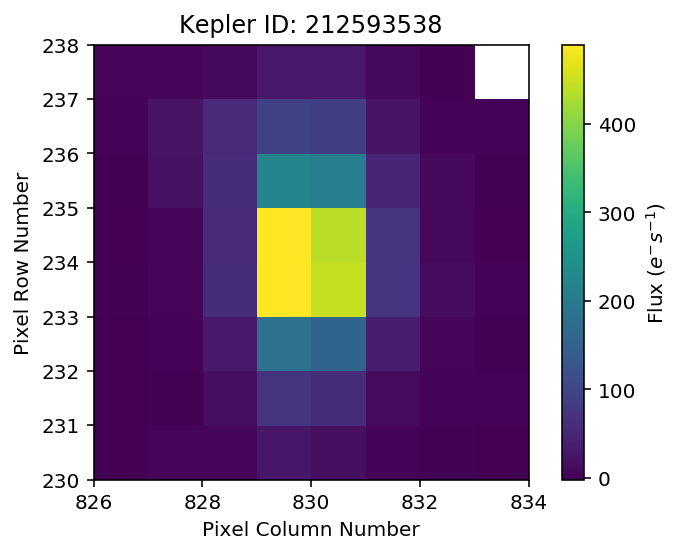

In [2]:
tpf.plot(frame=100);

The coarse angular resolution of Kepler means that this host galaxy resembles a pixelated blob.  We're showing frame 100 out of 3561 frames-- we do not presently know when the supernova went off so it's hard to say whether there is a supernova in the image or not.

One of the pixels is white, which represents `NaN` values in the color image.  In fact, this pixel within the $8 \times 8$ square postage stamp image boundary is `NaN` in all 3561 cadences, indicating that this TPF has an irregular boundary with $N_{\rm pix} = 63$.  Irregular boundaries are a common space-saving strategy for the distant Kepler telescope.

In [3]:
np.isnan(tpf.flux).sum(axis=0)[::-1] < 3561

array([[ True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

Let's make a lightcurve summing *all of the pixels* to see if we can pick out the FELT *by-eye*.  We will pre-process the lightcurve to remove sharp discontinuities in the time series that arise from spurious cosmic rays, not our astrophysical transients of interest.

In [4]:
lc = tpf.to_lightcurve(aperture_mask='all')
_, mask = lc.flatten().remove_outliers(return_mask=True)
lc_clean = lc[~mask]

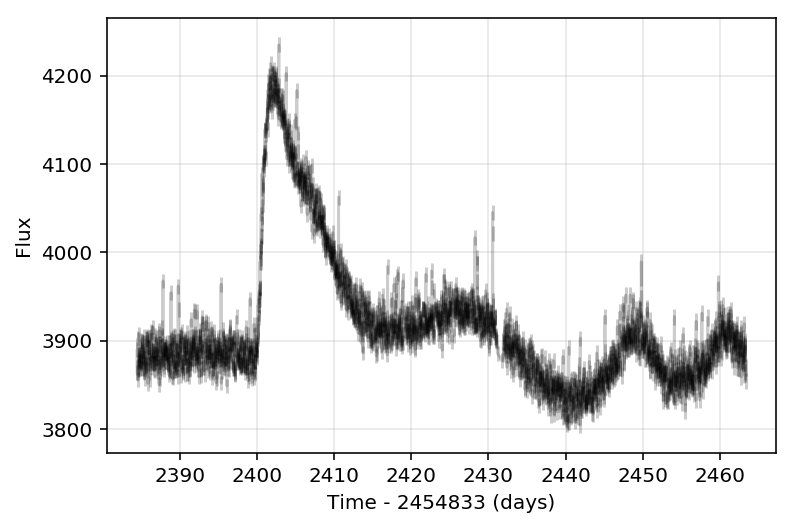

In [5]:
lc_clean.plot(alpha=0.2, normalize=False);

**Voilà**!  We indeed see what looks like a sharply-rising phenomenon at $t = 2400-2415$ days, distinct from the smoothly-varying background arising from either instrumental artifacts or host-galaxy or both.

Let's *interact* with the lightcurve to see if we can observe any change in the postage stamp images when the apparent outburst occurs.  You'll need to have `bokeh` installed for this new feature to work.  See our [interact tutorial](http://lightkurve.keplerscience.org/tutorials/1.05-interact-with-lightcurves-and-tpf.html) for more info.

In [6]:
tpf.interact(lc=lc_clean)

Loading BokehJS ...

A Jupyter Widget

A Jupyter Widget

It's not obvious where the transient is located within the image boundary, even with the `interact` tool.  The weak $\sim5\%$ signal defies human pattern recognition.  I can see lots of spacecraft motion jittering the postage stamp image back-and-forth, a common instrumental artifact in K2 data.  Let's attempt to mitigate the spacecraft motion with the SFF algorithm, knowing that it might delete some of the astrophysical signal of interest.

In [7]:
lc_corr = lc_clean.correct(restore_trend=True)

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


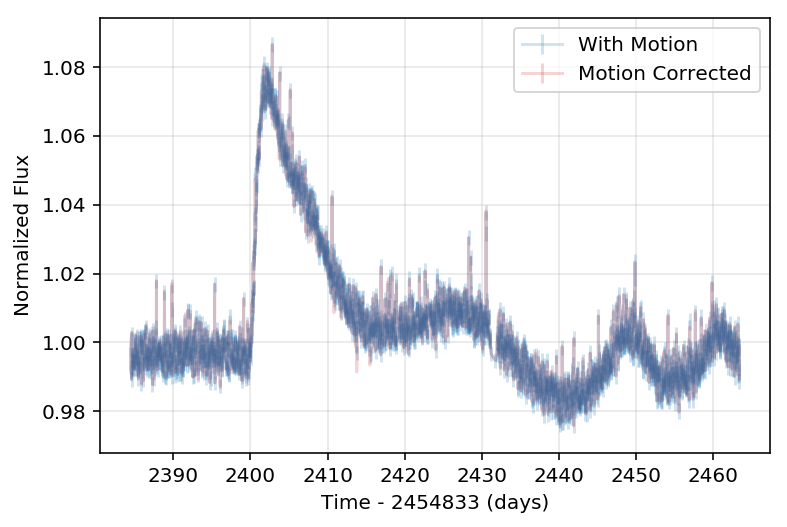

In [8]:
ax = lc_clean.plot(color='C0', alpha=0.2, label='With Motion')
ax = lc_corr.plot(ax=ax, color='C3', alpha=0.2, label='Motion Corrected');

The SFF method appears to do virtually nothing at all!  There are probably two primary reasons-- Our large aperture has captured all of the FELT + host galaxy flux, so the jitter motion has been subdued to the point where SFF has little or no constraining power.  A second effect is that large extended objects compensate for flux loss with equal parts of flux gain: flux from the right of the boundary enters when flux from the left exits.  This effect subdues the common jig-saw pattern attributable to flux overflowing the pixel mask.

It's conceivable---and likely--- that fine tuning the SFF parameters and pixel mask size would result in a higher signal-to-noise ratio lightcurve.  We are presently accepting lots of *variance* for the purpose of limiting *bias*.